<a href="https://colab.research.google.com/github/KimMunho/ComputerVision/blob/main/HW3/HW3_C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

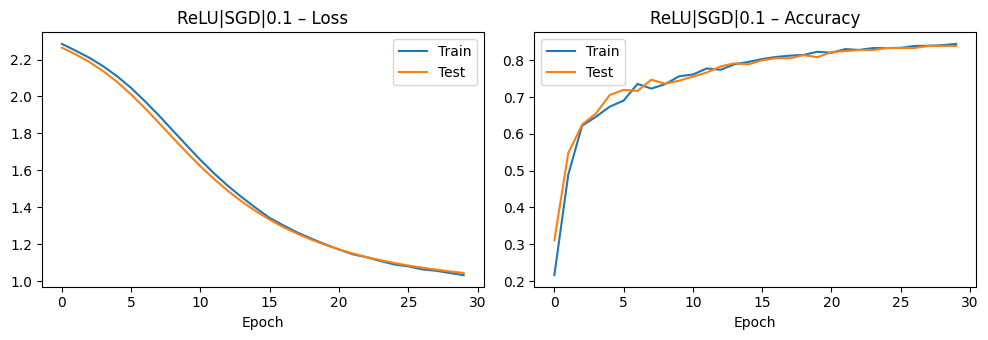

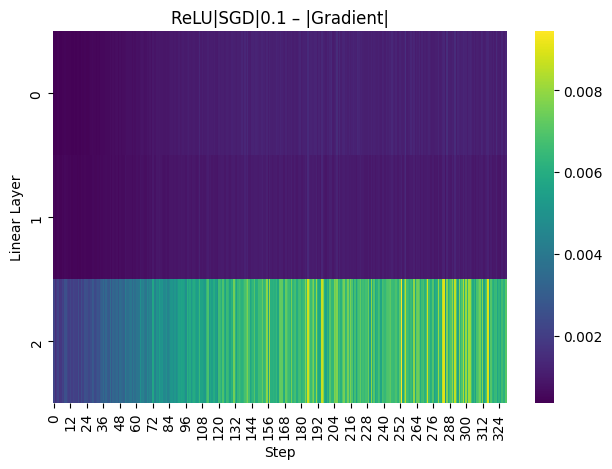

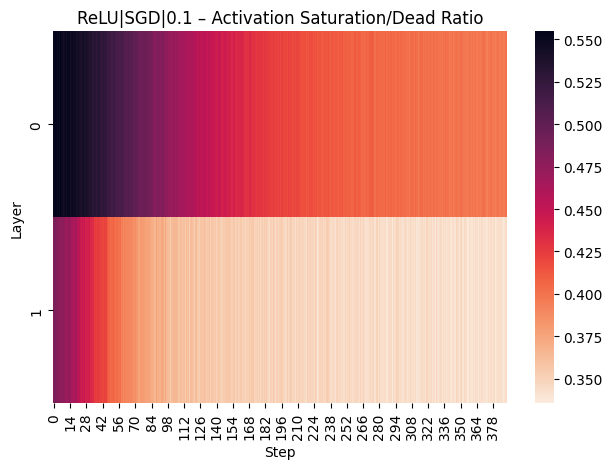

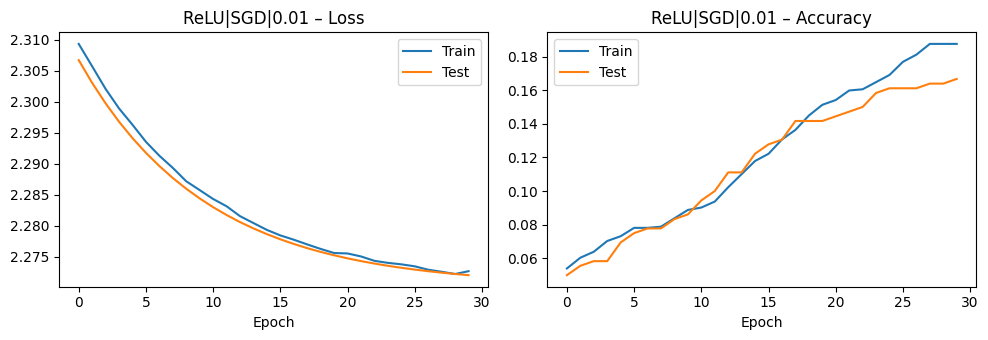

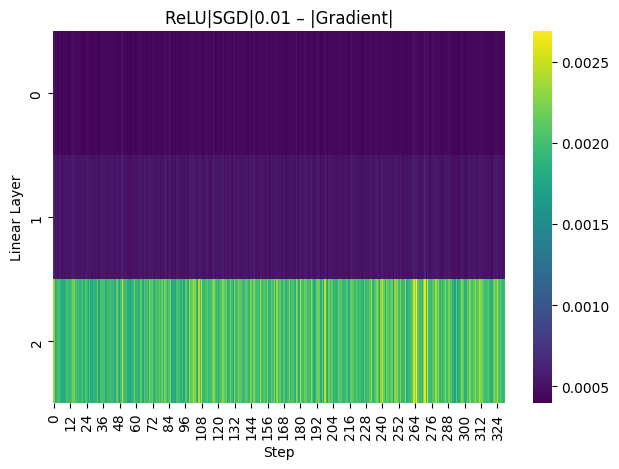

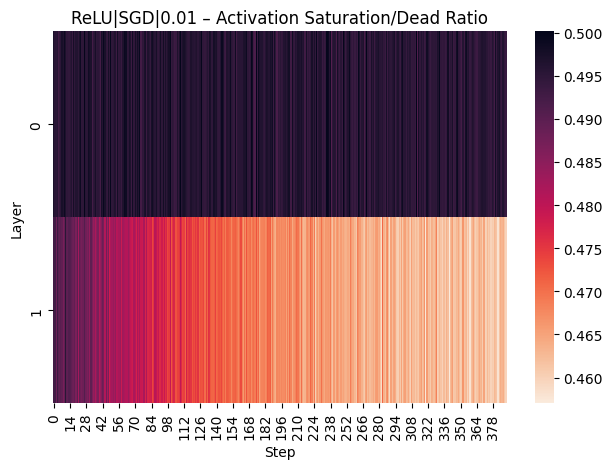

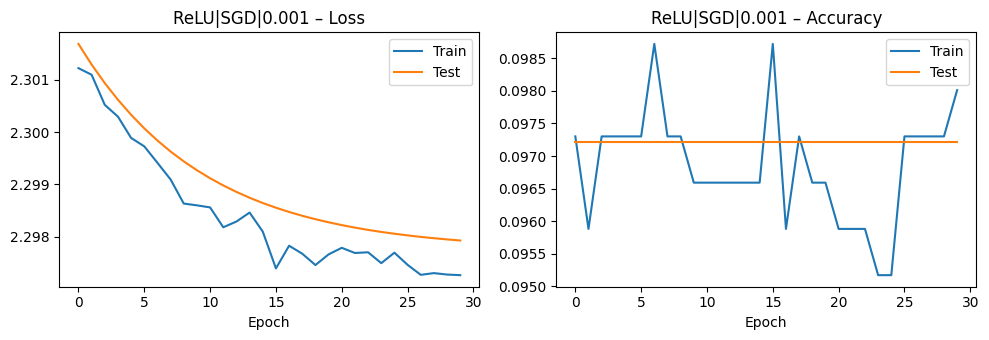

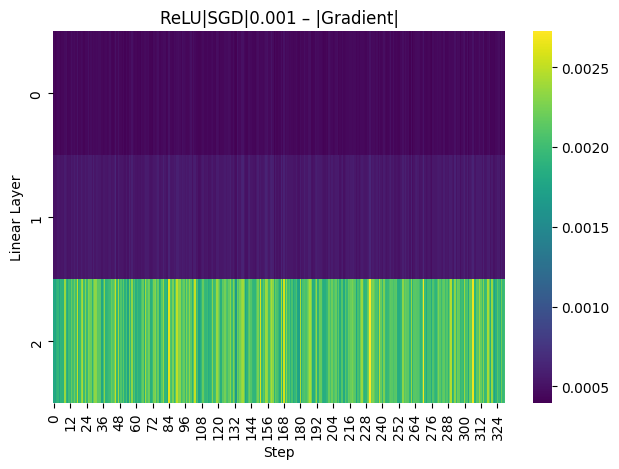

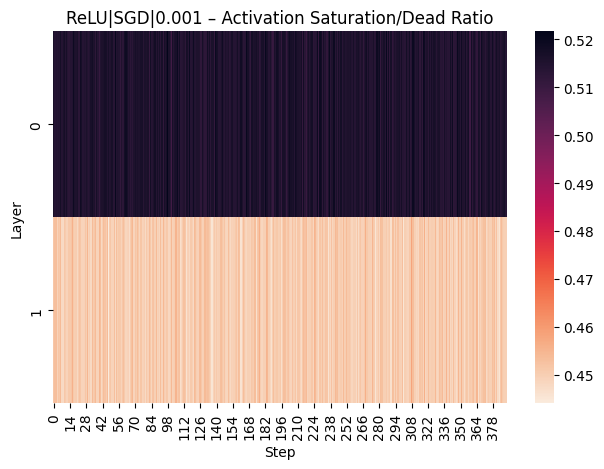

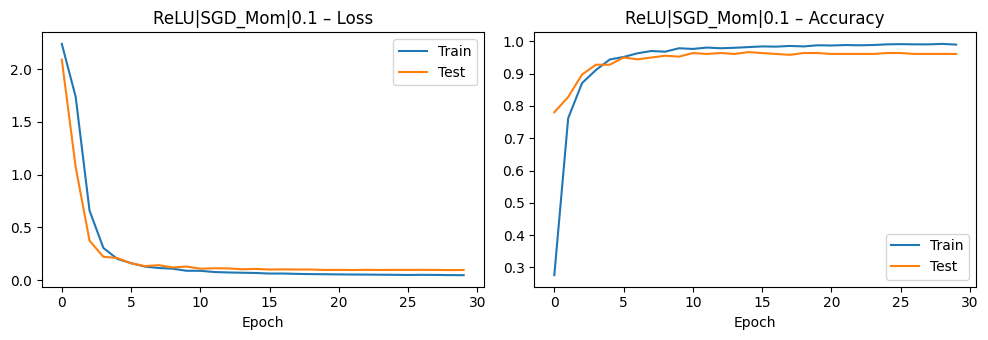

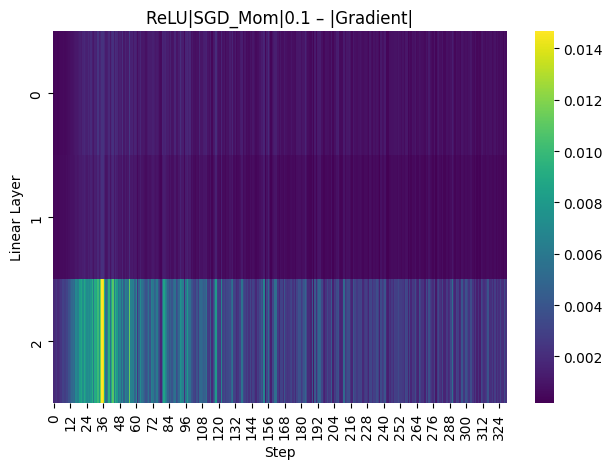

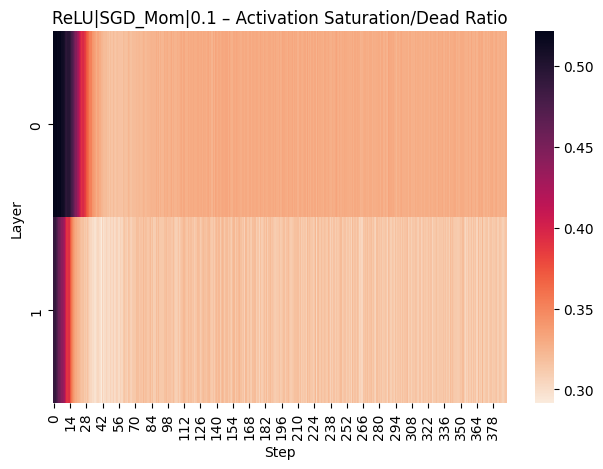

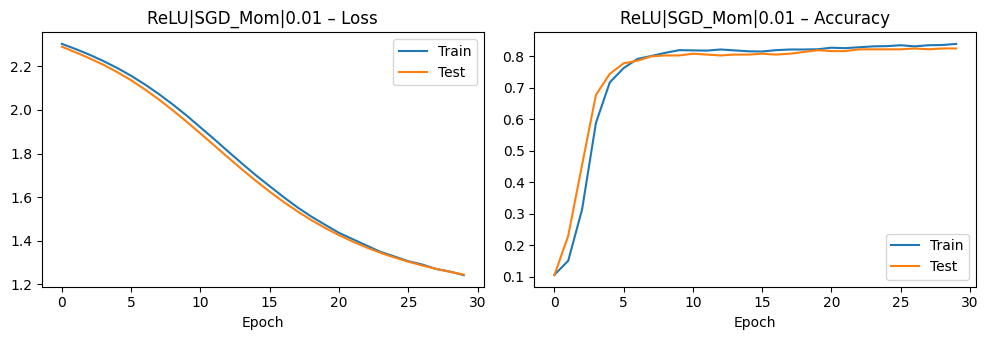

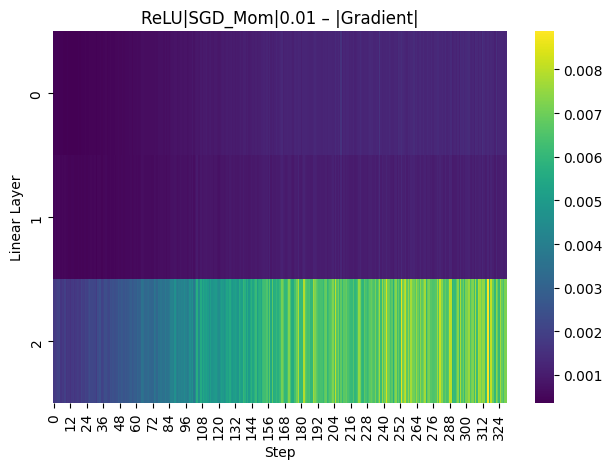

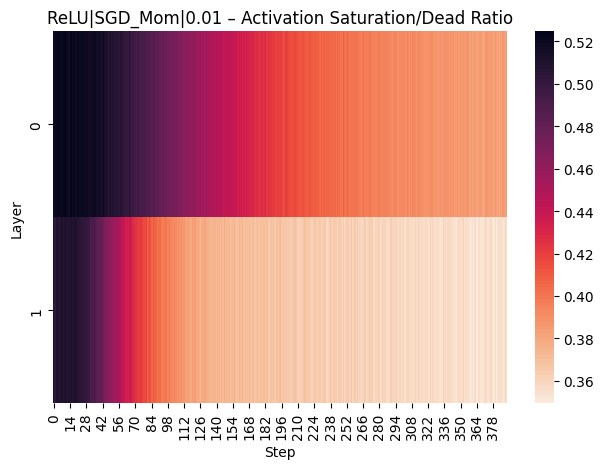

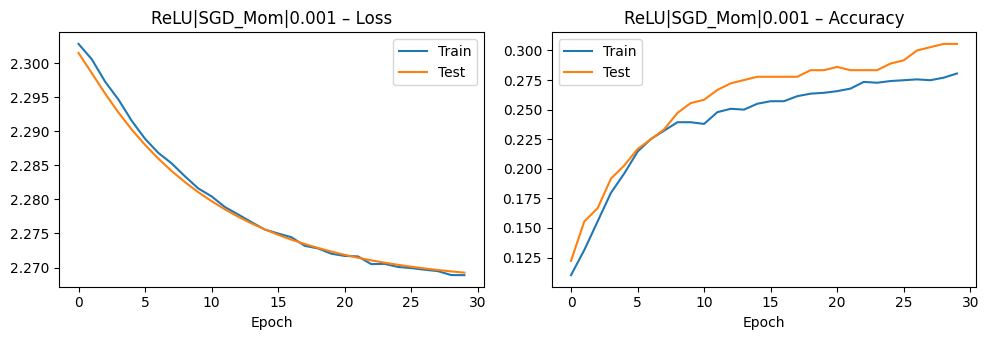

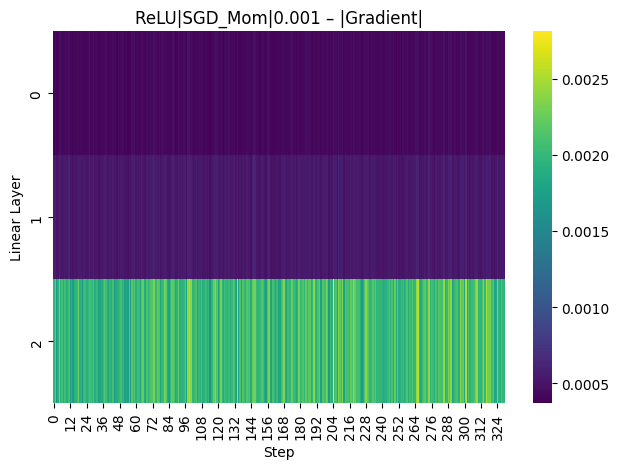

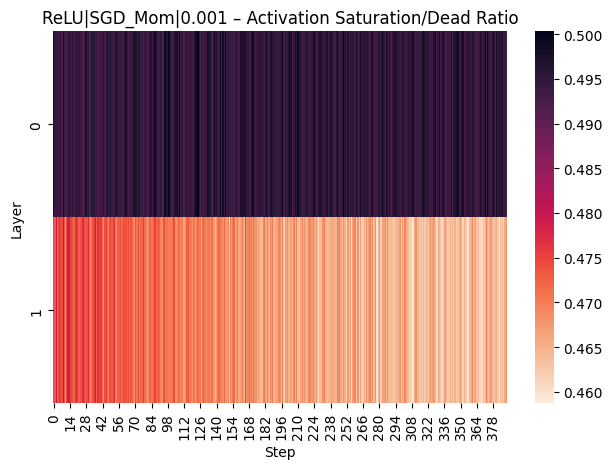

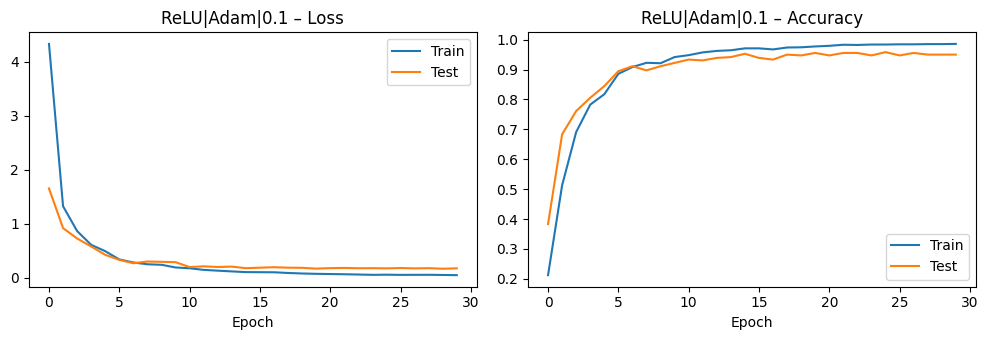

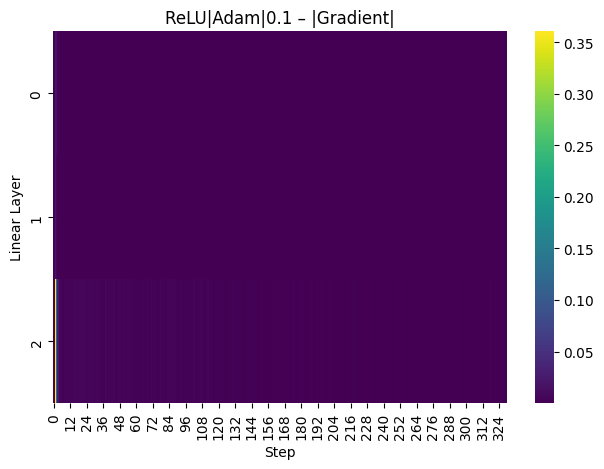

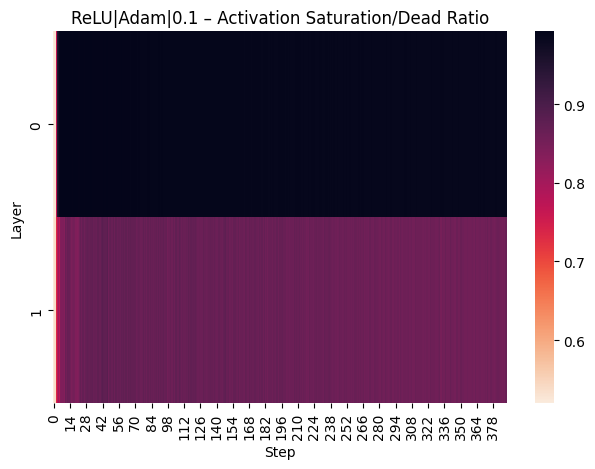

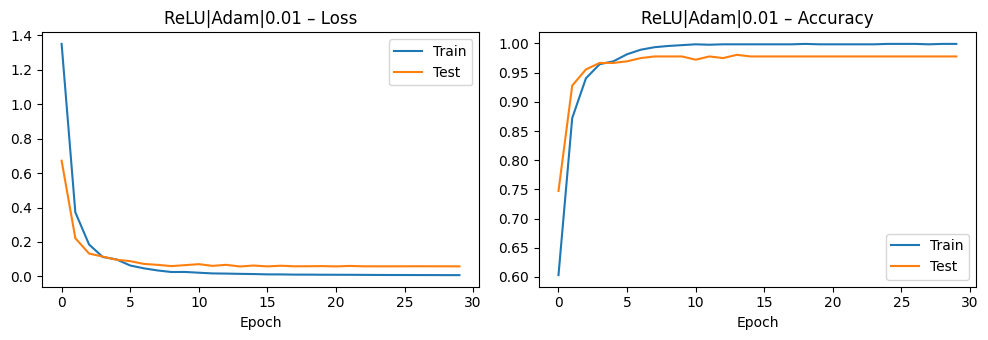

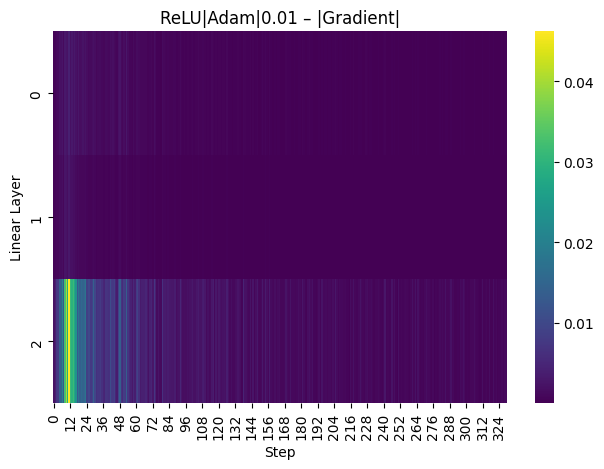

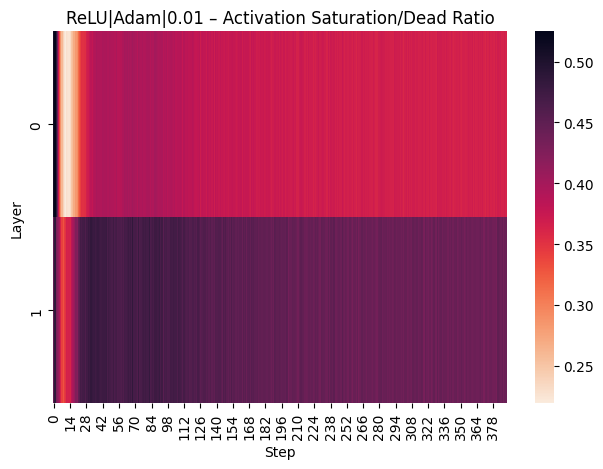

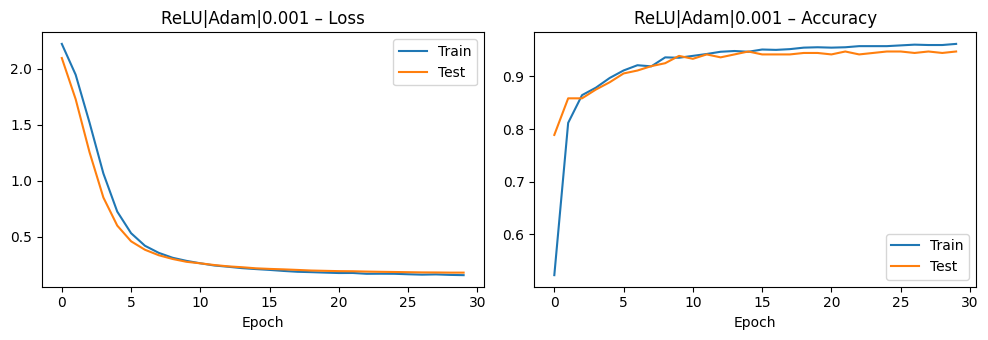

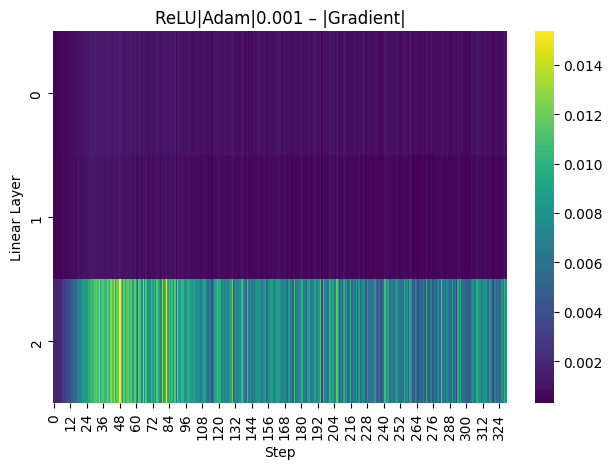

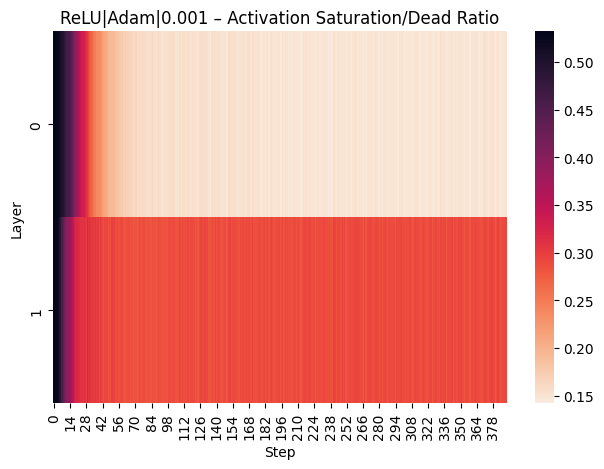

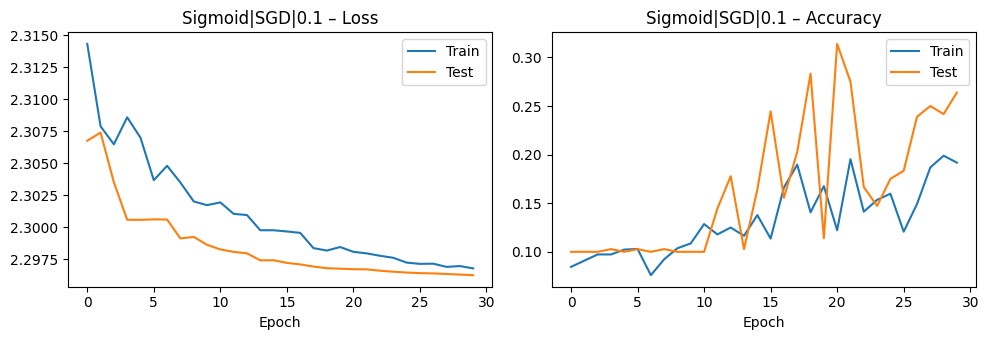

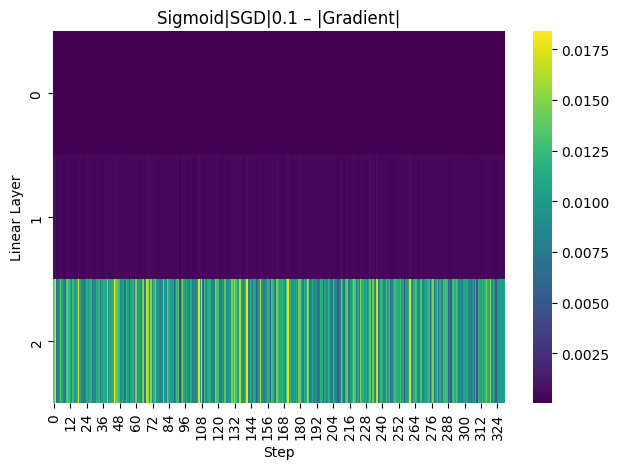

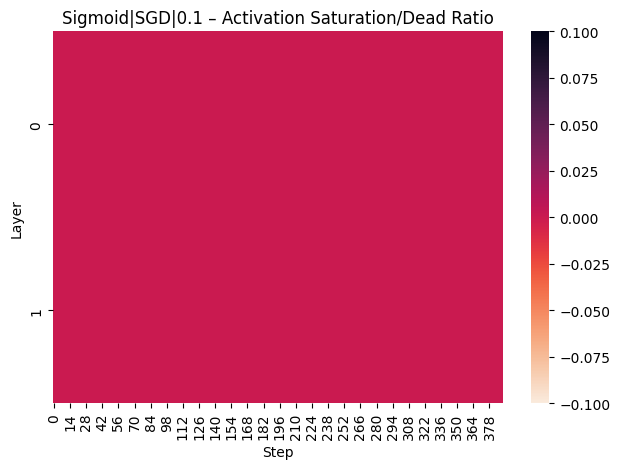

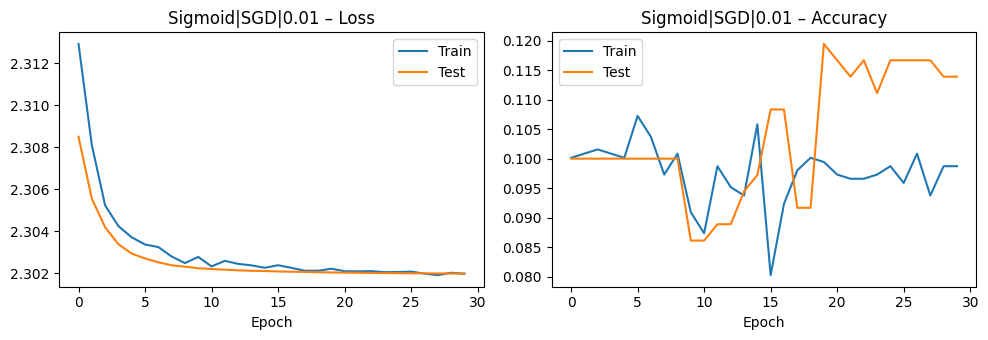

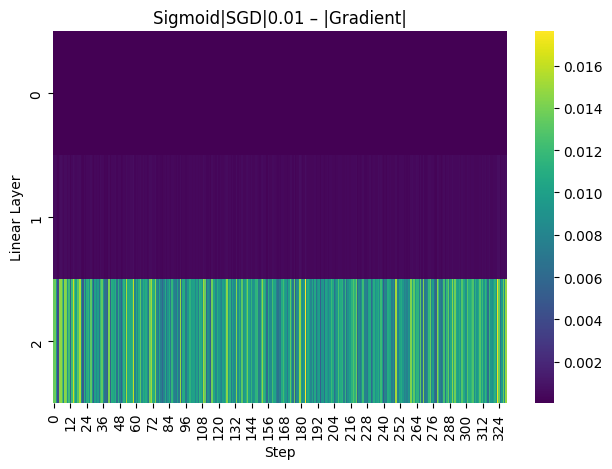

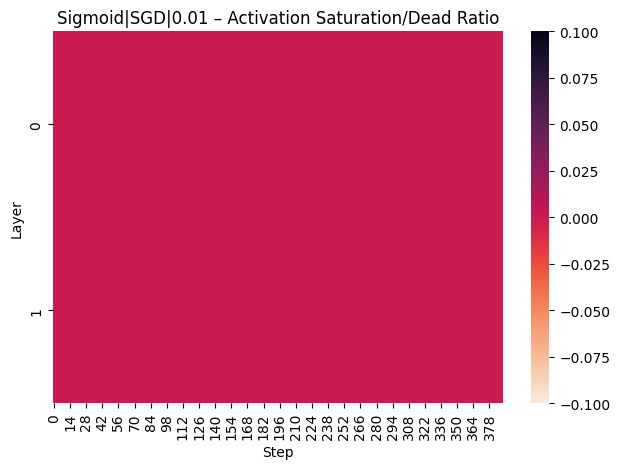

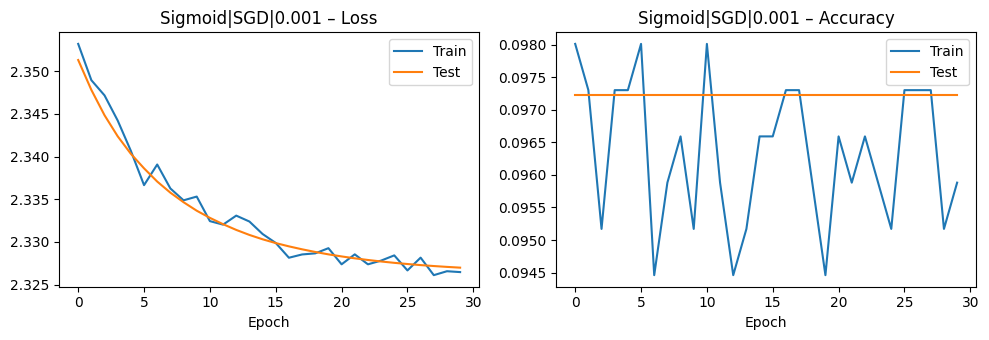

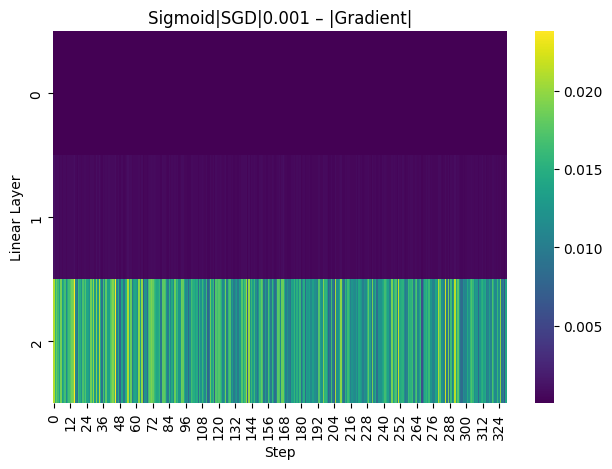

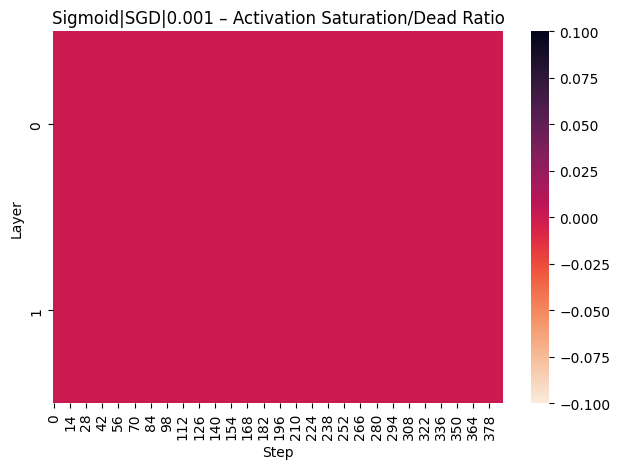

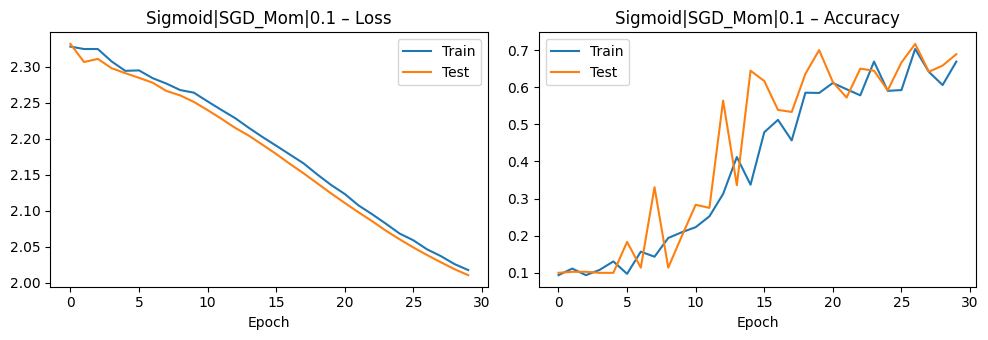

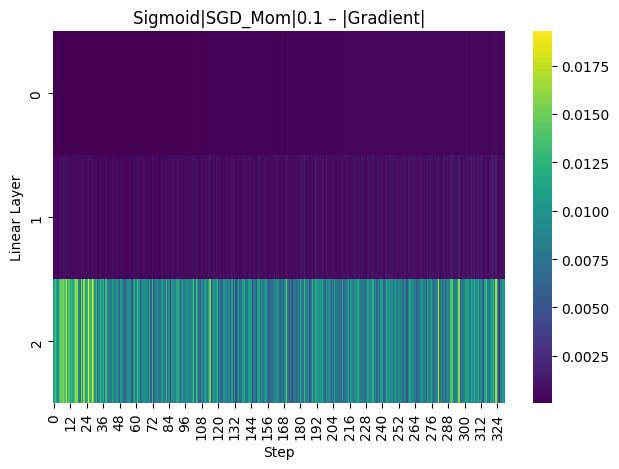

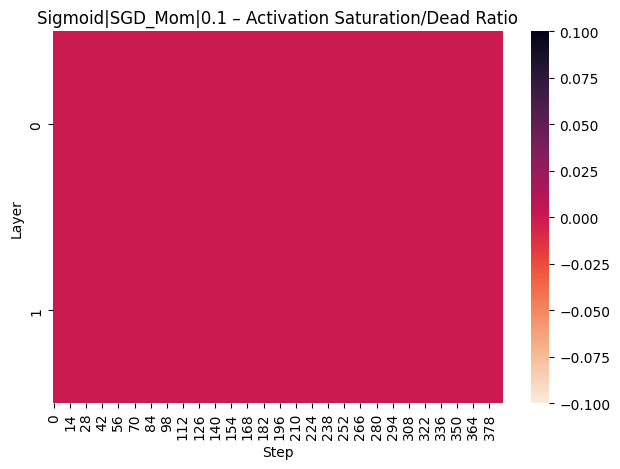

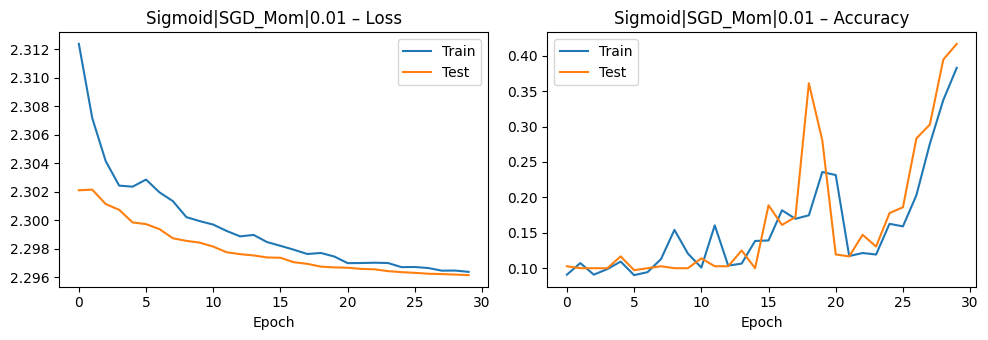

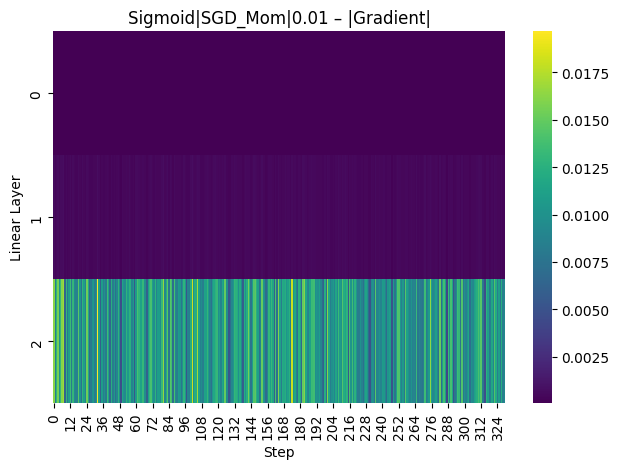

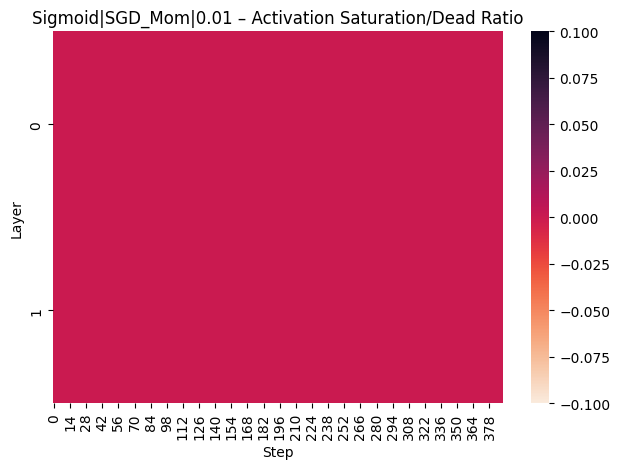

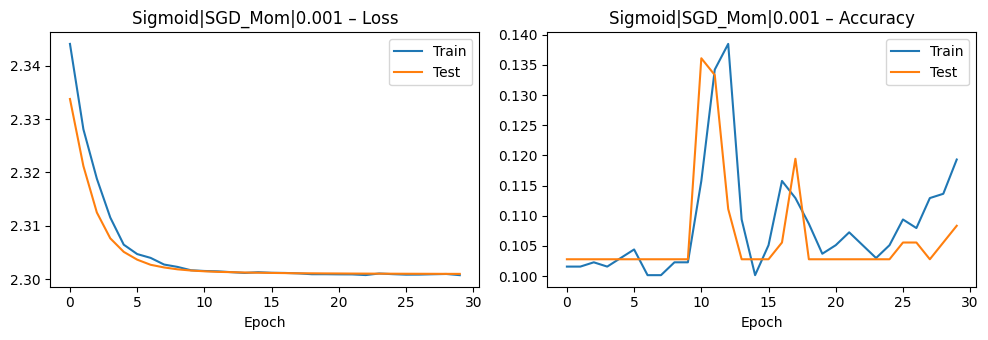

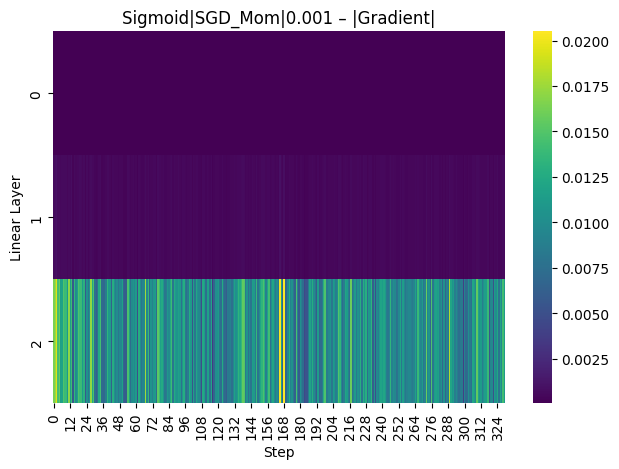

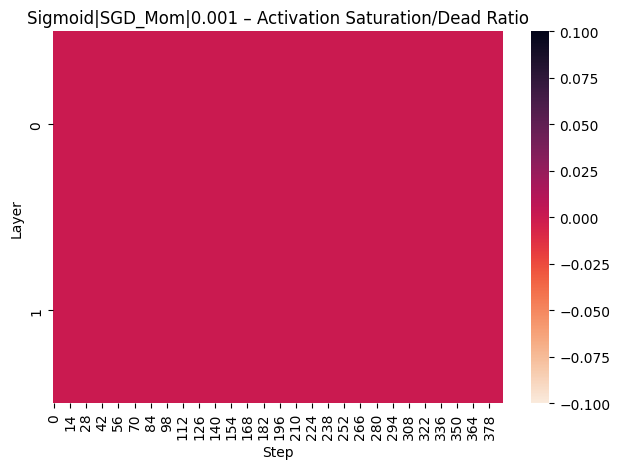

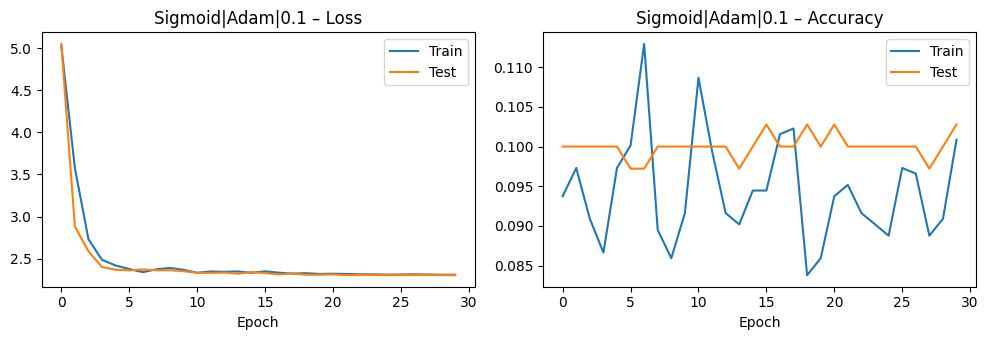

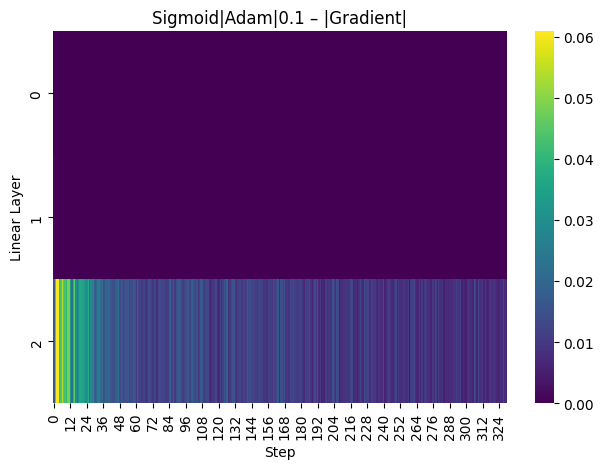

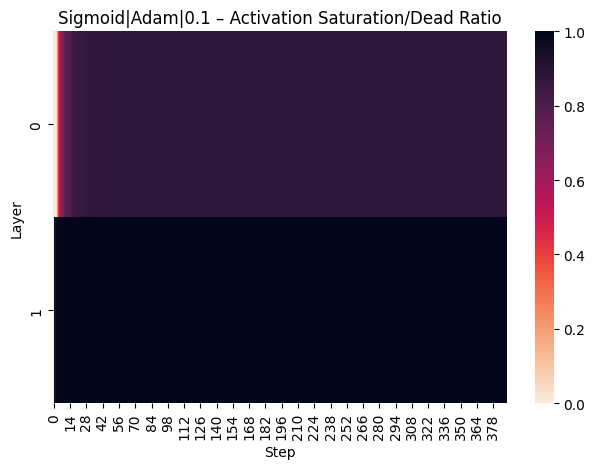

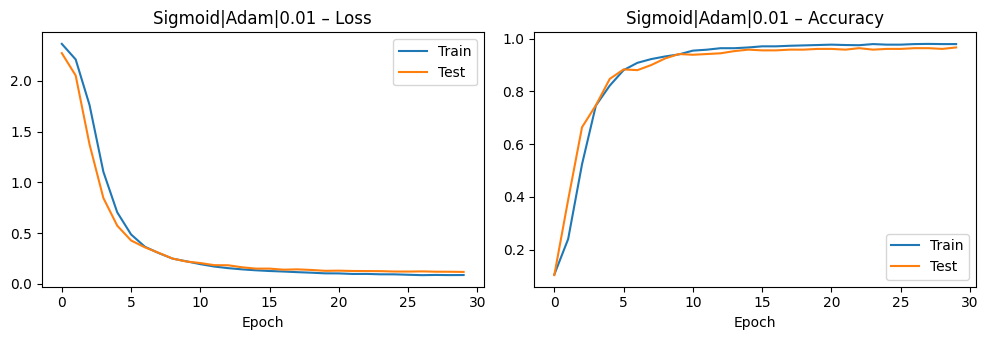

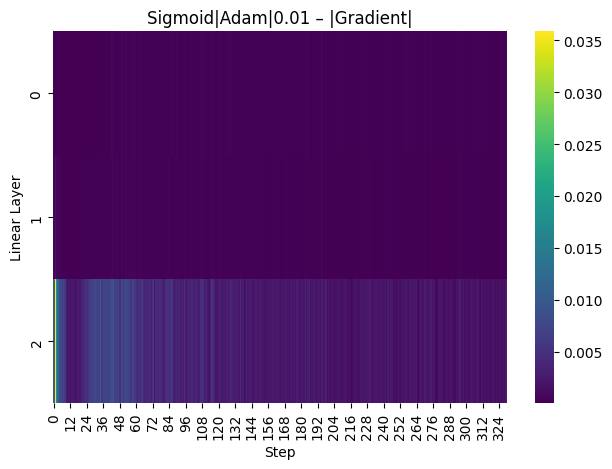

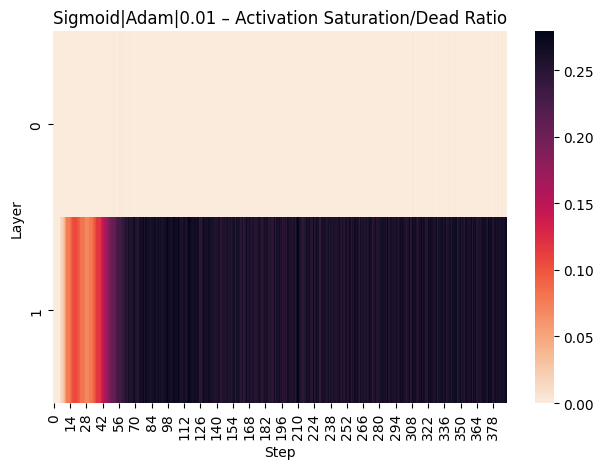

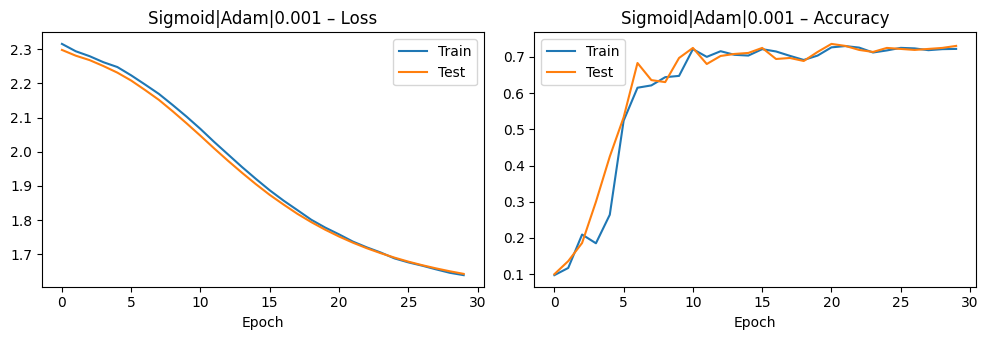

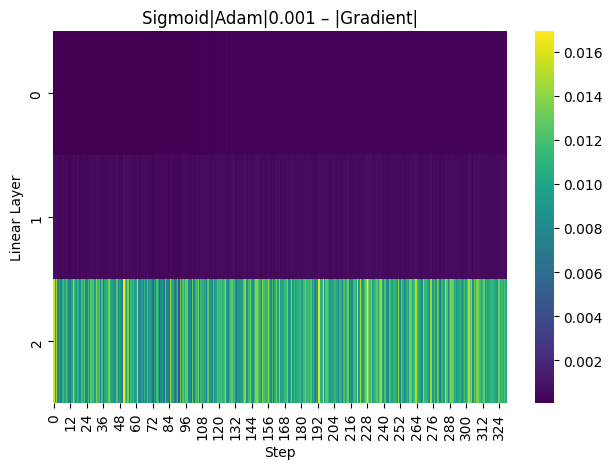

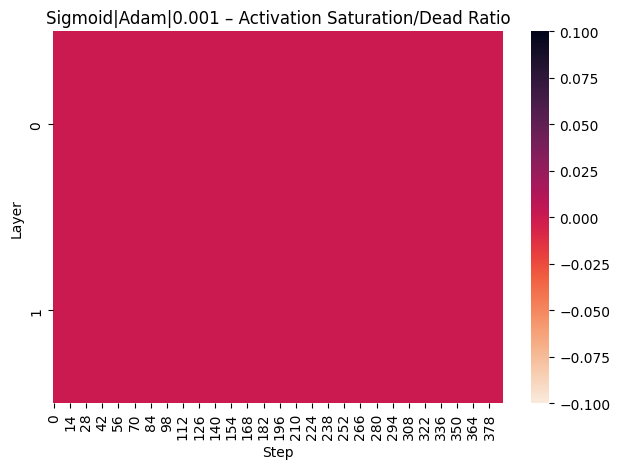


| Activation   | Optimizer   |    LR | 최종 정확도   |   수렴 Epoch | 안정성   |
|--------------|-------------|-------|---------------|--------------|----------|
| ReLU         | SGD         | 0.1   | 83.89%        |           28 | Stable   |
| ReLU         | SGD         | 0.01  | 16.67%        |           30 | Stable   |
| ReLU         | SGD         | 0.001 | 9.72%         |            1 | Stable   |
| ReLU         | SGD_Mom     | 0.1   | 96.11%        |           15 | Stable   |
| ReLU         | SGD_Mom     | 0.01  | 82.50%        |           27 | Stable   |
| ReLU         | SGD_Mom     | 0.001 | 30.56%        |           29 | Stable   |
| ReLU         | Adam        | 0.1   | 95.00%        |           25 | Stable   |
| ReLU         | Adam        | 0.01  | 97.78%        |           14 | Stable   |
| ReLU         | Adam        | 0.001 | 94.72%        |           15 | Stable   |
| Sigmoid      | SGD         | 0.1   | 26.39%        |           21 | Stable   |
| Sigmoid      | SGD         | 0.01  

In [3]:
import random, csv
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# ── 1. 설정 ───────────────────────────────────────────────────────────
SEED, DEVICE = 42, "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE, EPOCHS = 128, 30
HIDDEN_LAYERS     = [256, 128]
LR_LIST, OPTIMIZERS = [1e-1, 1e-2, 1e-3], ["SGD", "SGD_Mom", "Adam"]
ACTIVATIONS = ["ReLU", "Sigmoid"]

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ── 2. 데이터 ───────────────────────────────────────────────────────────
digits = load_digits()
X = digits.data.astype(np.float32) / 16.0
y = digits.target.astype(np.int64)
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED)

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_tr), torch.from_numpy(y_tr)),
    BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_te), torch.from_numpy(y_te)),
    BATCH_SIZE * 2, shuffle=False)

# ── 3. 모델 ────────────────────────────────────────────────────────────
class MLP(nn.Module):
    def __init__(self, dims, act_name="ReLU"):
        super().__init__()
        layers = []
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if i < len(dims) - 2:
                if act_name == "ReLU":
                    layers.append(nn.ReLU(inplace=True))
                else:
                    layers.append(nn.Sigmoid())
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# ── 4. Hook ─────────────────────────────────────────────────────────────
def register_hooks(model, act_dict, grad_dict):
    for name, m in model.named_modules():
        if isinstance(m, nn.ReLU):
            def f_hook(mod, inp, out, key=name):
                act_dict.setdefault(key, []).append((out <= 0).float().mean().item())
            m.register_forward_hook(f_hook)
        elif isinstance(m, nn.Sigmoid):
            def s_hook(mod, inp, out, key=name):
                sat = ((out < 0.01) | (out > 0.99)).float().mean().item()
                act_dict.setdefault(key, []).append(sat)
            m.register_forward_hook(s_hook)
        elif isinstance(m, nn.Linear):
            grad_dict.setdefault(name, [])
            def b_hook(g, key=name):
                grad_dict[key].append(g.abs().mean().item())
            m.weight.register_hook(b_hook)

# ── 5. 학습 루프 ────────────────────────────────────────────────────────
def run(act_name, opt_name, lr):
    model = MLP([64, *HIDDEN_LAYERS, 10], act_name).to(DEVICE)
    if opt_name == "SGD":
        optim = torch.optim.SGD(model.parameters(), lr=lr)
    elif opt_name == "SGD_Mom":
        optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    else:
        optim = torch.optim.Adam(model.parameters(), lr=lr)
    sched  = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)
    lossfn = nn.CrossEntropyLoss()

    act_log, grad_log = {}, {}
    register_hooks(model, act_log, grad_log)
    his = {k: [] for k in ["train_loss","train_acc","test_loss","test_acc"]}

    for ep in range(1, EPOCHS + 1):
        model.train(); tot = cor = ls = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optim.zero_grad()
            out = model(xb)
            loss = lossfn(out, yb)
            loss.backward(); optim.step()
            ls += loss.item() * yb.size(0)
            cor += (out.argmax(1) == yb).sum().item()
            tot += yb.size(0)
        his["train_loss"].append(ls / tot); his["train_acc"].append(cor / tot)

        model.eval(); tot = cor = ls = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                out = model(xb)
                ls += lossfn(out, yb).item() * yb.size(0)
                cor += (out.argmax(1) == yb).sum().item()
                tot += yb.size(0)
        his["test_loss"].append(ls / tot); his["test_acc"].append(cor / tot)
        sched.step()

    return his, act_log, grad_log

# ── 6. 실험 ─────────────────────────────────────────────────────────────
results = {}
for act in ACTIVATIONS:
    for opt in OPTIMIZERS:
        for lr in LR_LIST:
            key = f"{act}|{opt}|{lr}"
            his, dead, grad = run(act, opt, lr)
            results[key] = dict(
                history=his, dead=dead, grad=grad,
                final_acc=his["test_acc"][-1],
                conv_ep=int(np.argmax(his["test_acc"]) + 1)
            )

# ── 7. 시각화 ───────────────────────────────────────────────────────────
for key, pk in results.items():
    h = pk["history"]
    fig, ax = plt.subplots(1,2, figsize=(10,3.5))
    ax[0].plot(h["train_loss"], label="Train")
    ax[0].plot(h["test_loss"],  label="Test")
    ax[0].set_title(f"{key} – Loss");    ax[0].set_xlabel("Epoch"); ax[0].legend()
    ax[1].plot(h["train_acc"], label="Train")
    ax[1].plot(h["test_acc"],  label="Test")
    ax[1].set_title(f"{key} – Accuracy"); ax[1].set_xlabel("Epoch"); ax[1].legend()
    plt.tight_layout(); plt.show()

    gmat = np.vstack([pk["grad"][ln] for ln in pk["grad"]])
    sns.heatmap(gmat, cmap="viridis")
    plt.title(f"{key} – |Gradient|"); plt.xlabel("Step"); plt.ylabel("Linear Layer")
    plt.tight_layout(); plt.show()

    if pk["dead"]:
        dmat = np.vstack([pk["dead"][ln] for ln in pk["dead"]])
        sns.heatmap(dmat, cmap="rocket_r")
        plt.title(f"{key} – Activation Saturation/Dead Ratio")
        plt.xlabel("Step"); plt.ylabel("Layer")
        plt.tight_layout(); plt.show()

# ── 8. 정량 비교표 ──────────────────────────────────────────────────────
tbl = [
    [*key.split("|"), f"{results[key]['final_acc']*100:5.2f}%", results[key]['conv_ep'], "Stable"]
    for key in results
]
print("\n" + tabulate(
    tbl,
    headers=["Activation","Optimizer","LR","최종 정확도","수렴 Epoch","안정성"],
    tablefmt="github"
))
